In [77]:
import numpy as np
import os
import pandas as pd
import re
import torch
import glob

import matplotlib.pyplot as plt
from pydub import AudioSegment

%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [2]:
def confusion(Y, T, classes=None):
    if classes is None:
        classes = np.unique(T)
    confmat = np.zeros(
        (len(classes), len(classes)), dtype=int)
    for i in range(len(T)):
        confmat[T[i], Y[i]] += 1
    return confmat


def evaluate(Y, T, verbose=True):
    '''Given results, calculates the following:
    Precision, Recall, F1 for each class
    Accuracy overall
    Also, prints evaluation metrics in readable format.
    '''
    confmat = confusion(Y, T, np.unique(T))

    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.diag(confmat) / \
            np.sum(confmat, axis=0)  # tp / (tp + fp)
        recall = np.diag(confmat) / \
            np.sum(confmat, axis=1)  # tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)  # per class

    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)
    f1 = np.nan_to_num(f1)

    accuracy = np.trace(confmat) / len(T)

    if verbose:
        print_metrics(confmat, precision, recall, f1, accuracy, np.unique(T))

    return confmat, precision, recall, f1, accuracy


def print_confmat(confmat, class_names=None):
    classes = np.arange(
        confmat.shape[0]) if class_names is None else class_names
    spacing = len(str(np.max(confmat)))
    class_spacing = len(str(np.max(classes)))+1
    if class_spacing > spacing:
        spacing = class_spacing
    top = ' '*(class_spacing) + ''.join(' {i: < {spacing}}'.format(
        i=i, spacing=str(spacing)) for i in classes)
    t = ['{c:<{spacing}} |'.format(c=classes[j], spacing=str(spacing-1)) + ''.join(' {i:<{spacing}}'.format(
        i=i, spacing=str(spacing)) for i in row) for j, row in enumerate(confmat)]
    hdr = ' '*class_spacing + '-'*(len(t[0]) - class_spacing)
    print('Confusion Matrix:', top, hdr, '\n'.join(t), sep='\n')
    
    
def print_metrics(confmat, precision, recall, f1, accuracy, class_names):
    # Print Classes
    wrap = '-'*40
    print(wrap)
    # print('Classes:', ', '.join(f'{k}: {v}' for k,
    #                             v in self.class_dict.items()), end='\n\n')
    # Print Confusion Matrix
    print_confmat(confmat, class_names=class_names)

    # All-Class Metrics
    labels = ['Precision', 'Recall', 'F1']
    precision = np.append(precision, precision.mean())
    recall = np.append(recall, recall.mean())
    f1 = np.append(f1, 2*precision.mean()*recall.mean() /
                   (precision.mean()+recall.mean()))
    # Print Metrics
    metrics = np.vstack([precision, recall, f1])
    label_spacing = max([len(l) for l in labels])+1
    metric_spacing = max([len(f'{m:.3f}') for m in metrics.flatten()])
    mean = '  mean'
    top = ' '*(label_spacing) + ''.join(' {i: < {spacing}}'.format(
        i=i, spacing=str(metric_spacing)) for i in class_names) + mean
    t = ['{i:<{spacing}}|'.format(i=labels[j], spacing=str(label_spacing)) + ''.join(f' {i:.3f}' for i in row)
         for j, row in enumerate(metrics)]
    hdr = ' '*label_spacing + '-'*(len(t[0]) - label_spacing)
    print('\nMetrics:', top, hdr, '\n'.join(t), sep='\n')
    # Print Accuracy
    print(f'\nOverall Accuracy: {accuracy*100:.3f} %')
    print(wrap)



## Data Loader

In [168]:
VOL = '/s/chopin/l/grad/stock/nvme/data/cs542/project'
LABELS = ['World', 'Sports', 'Business', 'Sci-Tech']

def clean_text(desc):
    def replace(s):
        s = re.sub(r'\\', ' ', s)
        s = re.sub(r'&lt;.*&gt;|<.*?>+', '', s)
        s = re.sub(r'#36;', '$', s)
        s = re.sub(r'\s+hellip;', '...', s)
        s = re.sub(r'#[0-9]+;|<.*?>+', '', s)
        s = s.encode('utf-8').decode('ascii', 'ignore')
        s = re.sub(r'\s+,', ',', s)
        s = re.sub(r'\s+\.', '.', s)
        s = re.sub('\s+', ' ', s)
        return s.strip()
    return np.array([replace(s) for s in desc]) #remove \n \t

def loadtext(f):
    df = pd.read_csv(f, names=['class', 'title', 'desc'], skiprows=1, header=None)
    df['class'] = df['class'].apply(lambda x: x-1)
    desc = clean_text(df['title'] + '. ' + df['desc'])
    return desc, df['class'].values.reshape(-1,1)

Xtrain, Ttrain = loadtext(os.path.join(VOL,'train.csv'))
Xtest, Ttest = loadtext(os.path.join(VOL,'test.csv'))
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((120000,), (120000, 1), (7600,), (7600, 1))

In [169]:
splitsample = True

if splitsample:
    # need to partition further to fix long phrase issue...
    # https://github.com/NVIDIA/DeepLearningExamples/issues/1020
    def splitfurther(X, maxlen=30):
        rs = []
        genrx = lambda k : r'(?<!\w\{key}\w{key})(?<![A-Z][a-z]\{key})(?<=\{key}|\?)\s'.format(key=k)
        for i,desc in enumerate(X):
            # split on period, comma, then ." period at end of quote.
            parsed = re.split('|'.join([genrx('.'),genrx(','),r'(?<=\.\")(?!$)']), desc)
            split = []
            for s in parsed:
                ss = s.split()
                split.extend([' '.join(ss[i:i+maxlen]) for i in range(0,len(ss),maxlen)])
            split = [s for s in split if len(s) > 1]
            p = len(str(len(split)))
            for j,s in enumerate(split):
                s = s.strip()
                if len(s) < 2:
                    print(f'Empty str for sample {i} and split {s}')
                rs.append({'output':'i{i}_{v1:0{p}}_{v2:0{p}}.wav'.format(i=i, v1=j+1, v2=len(split), p=str(p)),
                           'text':s})
        return pd.DataFrame(rs)
    
    df = splitfurther(Xtrain)
    df.to_csv(os.path.join(VOL,'audio/components/phrases/train.tsv'), sep = '\t', index=False)
    df = splitfurther(Xtest)
    df.to_csv(os.path.join(VOL,'audio/components/phrases/test.tsv'), sep = '\t', index=False)
else:
    df = pd.DataFrame({'output':[f'{i}.wav' for i in range(len(Xtrain))], 'text':Xtrain})
    df.to_csv(os.path.join(VOL,'audio/components/phrases/train.tsv'), sep = '\t', index=False)
    df = pd.DataFrame({'output':[f'{i}.wav' for i in range(len(Xtest))], 'text':Xtest})
    df.to_csv(os.path.join(VOL,'audio/components/phrases/test.tsv'), sep = '\t', index=False)

(1347, 80)


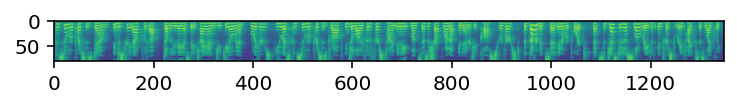

In [166]:
componentdir = 'audio/components/output/test'
jointdir = 'audio/joint/test'
for i in range(len(Xtest[:100])):
    wavfiles = sorted(glob.glob(os.path.join(VOL, componentdir, f'i{i}_*.wav')))
    audio = sum([AudioSegment.from_wav(f) for f in wavfiles])
    audio.export(os.path.join(VOL, jointdir, f'i{i}.wav'), format='wav')
    npyfiles = sorted(glob.glob(os.path.join(VOL, componentdir, f'i{i}_*.npy')))
    mel = np.vstack([np.load(f) for f in npyfiles])
    np.save(os.path.join(VOL, jointdir, f'i{i}.npy'), mel)
plt.imshow(mel.T)
print(mel.shape)
audio

## A

In [14]:
device = torch.device('cpu')
torch.set_num_threads(4)
modelf = 'https://models.silero.ai/models/tts/en/v2_lj.pt'
local_file = os.path.join(VOL, 'silero', 'model.pt')
model_name = modelf.rpartition('/')[-1]

if not os.path.isfile(local_file):
    torch.hub.download_url_to_file(modelf, local_file)  

model = torch.package.PackageImporter(local_file).load_pickle('tts_models', 'model')
model.to(device)

example_batch = [Xtest[7591]]
sample_rate = 16000

audio_paths = model.save_wav(texts=example_batch,
                             sample_rate=sample_rate)
print(audio_paths)

<torch_package_1>.mono_v2_package.py:22: UserWarning: Text string is longer than 140 symbols.
  warnings.warn('Text string is longer than 140 symbols.')


['test_000.wav']


## Audio Preview

In [24]:
v = '/s/chopin/l/grad/stock/nvme/data/cs542/project/DeepLearningExamples/PyTorch/SpeechSynthesis/FastPitch/output/'
mel1 = np.load(v + 'audio_devset10/010_during_the_morning_of_november_twenty-two.npy')
mel2 = np.load(v + 'audio_devset10/009_the_first_physician_to_see_the.npy')
mel3 = np.load(v + 'audio_benchmark_8_128/01_his_dissapearance_gave_color_and_substance.npy')
mel1.shape, mel2.shape, mel3.shape

((307, 80), (640, 80), (683, 80))

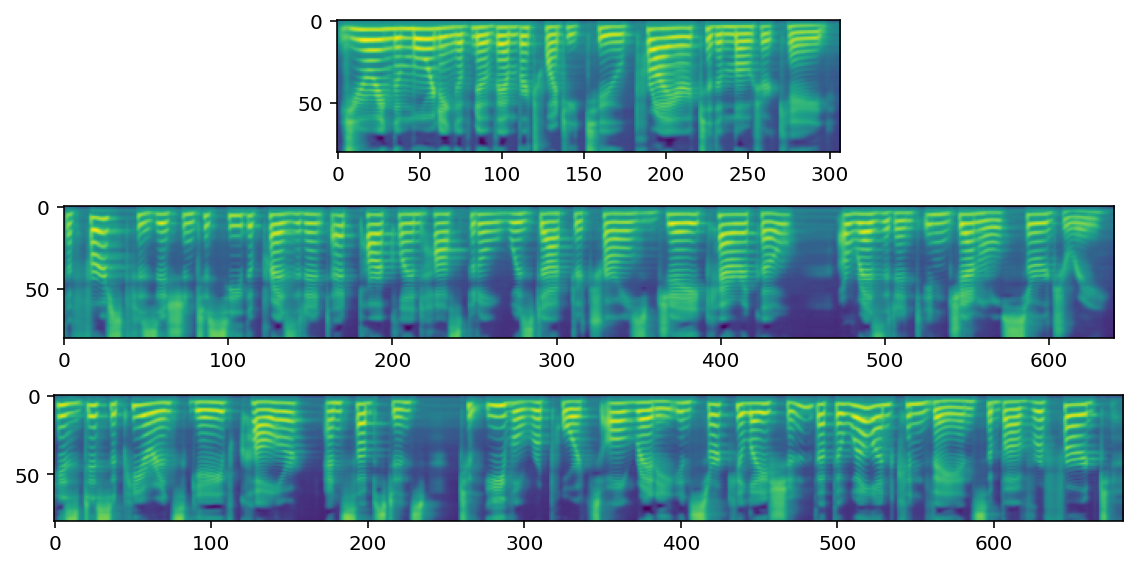

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(8, 4))
axs[0].imshow(mel1.T)
axs[1].imshow(mel2.T)
axs[2].imshow(mel3.T)
fig.tight_layout()

In [ ]:
# use /s/chopin/l/grad/stock/nvme/data/cs542/project/
# DeepLearningExamples/PyTorch/SpeechSynthesis/FastPitch/common/text/text_processing.py